# Building the best classifier
We build classifiers based on random forest, because we want to interpret the model. RF have easy to extract and justify feature importances, as opposed to XGB, where there is a dependency between the decision trees.

In [2]:
# this is copypasted from Classifiers.ipynb
import numpy as np
import pandas as pd
import openpyxl
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,root_mean_squared_error
from xgboost import XGBClassifier
import sklearn
from sklearn.metrics import make_scorer, matthews_corrcoef, balanced_accuracy_score
from tqdm import tqdm
import itertools

In [ ]:
MFPGEN = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
AFPGEN = rdFingerprintGenerator.GetAtomPairGenerator(fpSize=2048)
RFPGEN = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=2048)
TTPGEN = rdFingerprintGenerator.GetTopologicalTorsionGenerator(fpSize=2048)

def calculate_descriptors(mol, missingVal = 0.0):
    """Calculate the full list of descriptors for a molecule.
    adapted from
    https://github.com/jonswain/tabpfn-tdc/blob/main/submission.py#L12
    """
    
    res = []
    for nm, fn in Descriptors._descList:
        try:
            if nm!="Ipc": # this one creates crazy values so we exclude it
                val = fn(mol)
        except:
            val = missingVal
        res.append(val)
    return res

def mol_feat(mol,morgan=True,tt=True,ap=True,descs=True,rdfp=True):
    """
    Extracts features by combining:
    - Morgan Fingerprints
    - RDKit Descriptors
    - Topological Torsion Fingerprints
    Returns a concatenated NumPy array of all features.
    """
    assert mol is not None, "Invalid molecule."
    features = []

    #combine the features:
    if morgan:
        morgan_fp = MFPGEN.GetFingerprintAsNumPy(mol)
        features.append(morgan_fp)
    if tt:
        torsion_fp = TTPGEN.GetFingerprintAsNumPy(mol)
        features.append(torsion_fp)
    if ap:
        ap_fp = AFPGEN.GetFingerprintAsNumPy(mol)
        features.append(ap_fp)
    if descs:
        rdkit_desc = calculate_descriptors(mol)  
        features.append(rdkit_desc)
    if rdfp:
        rdkit_fp = RFPGEN.GetFingerprintAsNumPy(mol)
        features.append(rdkit_fp)

    # Concatenate all features into a single vector
    combined_features = np.hstack(features)
    
    return combined_features


def build_classification_model(X,y,mode="RandomForest",model_options={"n_estimators":10,"max_depth":3,"random_state":123}):
    if mode == "RandomForest":
        model = RandomForestClassifier(**model_options)
    elif mode == "XGBoost":
        model = XGBClassifier(**model_options)
    elif mode == "Ridge":
        model = RidgeClassifier(**model_options)
    elif mode == "SVM":
        model = SVC(**model_options)
    else:
        print("mode not supported")
    model.fit(X,y)
    return model

def data_splitter(X,y,mode="Random",test_ratio=0.2,seed=123):
    if mode == "Random":
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=test_ratio,random_state=seed)
    else:
        print("mode not supported")    
    return X_train,X_test,y_train,y_test

m = Chem.MolFromSmiles("c1ccccc1")

In [4]:
df_chembl = pd.read_csv("data/PDL1-CHEMBL.csv", sep=";")
mols = []
y = []

threshold = 6.0  

for i, row in df_chembl.iterrows():
    smiles = row["Smiles"]
    try:
        pchembl = float(row["pChEMBL Value"])
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            y.append(1 if pchembl >= threshold else 0)
            mols.append(mol)
    except:
        continue  

X_chembl_ecfp = [mol_feat(m, descs=False, morgan=True, rdfp=False, ap=False, tt=False) for m in mols]
X_chembl_rdk = [mol_feat(m, descs=False, morgan=False, rdfp=True, ap=False, tt=False) for m in mols]
y_chembl = np.array(y)

In [5]:
df_paper = pd.read_excel("data/pharmaceuticals-1710563-supplementary.xlsx")
smiles_paper = list(set(df_paper[df_paper["Unnamed: 2"] == "ACTIVE"]["Unnamed: 3"]))
smiles_paper_decoys = list(set(df_paper[df_paper["Unnamed: 2"] == "DECOY"]["Unnamed: 3"]))

mols = [Chem.MolFromSmiles(smi) for smi in smiles_paper+smiles_paper_decoys]
X_paper_ecfp = [mol_feat(m, descs=False, morgan=True, rdfp=False, ap=False, tt=False) for m in mols]
X_paper_rdk = [mol_feat(m, descs=False, morgan=False, rdfp=True, ap=False, tt=False) for m in mols]
y_paper = [1]*len(smiles_paper)+[0]*len(smiles_paper_decoys)

In [3]:
X_features = {"ecfp":X_paper_ecfp+X_chembl_ecfp,"rdk":X_paper_rdk+X_chembl_rdk}
y = y_paper+list(y_chembl)

In [4]:
# model based on ECFP
X = X_features["ecfp"]
X_train, X_test, y_train, y_test = data_splitter(X, y,seed=123)
rf_ecfp_model = build_classification_model(X_train, y_train, mode="RandomForest",
                                       model_options={"n_jobs":-1, "n_estimators":806, "max_depth":21, "random_state":102})

In [5]:
# print the metrics
print(f"RF ECFP metrics:")
score = sklearn.model_selection.cross_val_score(rf_ecfp_model, X_train, y_train, n_jobs=-1, cv=5,scoring=make_scorer(matthews_corrcoef))
print("CV MCC ",round(score.mean(),3))

score = sklearn.model_selection.cross_val_score(rf_ecfp_model, X_train, y_train, n_jobs=-1, cv=5,scoring=make_scorer(balanced_accuracy_score))
print("CV,bAcc",round(score.mean(),3))

y_pred = rf_ecfp_model.predict(X_test)
print("test MCC ",round(matthews_corrcoef(y_test,y_pred),3))
print("test bAcc",round(balanced_accuracy_score(y_test,y_pred),3))

RF ECFP metrics:


Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/home/hunzallah/miniconda3/envs/my-rdkit-env/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/hunzallah/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/joblib/externals/loky/backend/synchronize.py", line 112, in _cleanup
    resource_tracker.unregister(name, "semlock")
  File "/home/hunzallah/miniconda3/envs/my-rdkit-env/lib/python3.10/multiprocessing/resource_tracker.py", line 159, in unregister
    self._send('UNREGISTER', name, rtype)
  File "/home/hunzallah/miniconda3/envs/my-rdkit-env/lib/python3.10/multiprocessing/resource_tracker.py", line 162, in _send
    self.ensure_running()
  File "/home/hunzallah/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 102, in ensure_running
    if self._check_alive():
  File "/home/hunzallah/miniconda3/e

In [6]:
# model based on RDK
X = X_features["rdk"]
X_train, X_test, y_train, y_test = data_splitter(X, y,seed=123)
rf_rdk_model = build_classification_model(X_train, y_train, mode="RandomForest",
                                       model_options={"n_jobs":-1, "n_estimators":256, "max_depth":15, "random_state":102})

In [ ]:
# print the metrics
print(f"RF RDK metrics:")
score = sklearn.model_selection.cross_val_score(rf_rdk_model, X_train, y_train, n_jobs=-1, cv=5,scoring=make_scorer(matthews_corrcoef))
print("CV MCC ",round(score.mean(),3))

score = sklearn.model_selection.cross_val_score(rf_rdk_model, X_train, y_train, n_jobs=-1, cv=5,scoring=make_scorer(balanced_accuracy_score))
print("CV,bAcc",round(score.mean(),3))

y_pred = rf_rdk_model.predict(X_test)
print("test MCC ",round(matthews_corrcoef(y_test,y_pred),3))
print("test bAcc",round(balanced_accuracy_score(y_test,y_pred),3))

In [7]:
# model based on RDK
X = X_features["rdk"]
X_train, X_test, y_train, y_test = data_splitter(X, y,seed=123)
xgb_rdk_model = build_classification_model(X_train, y_train, mode="XGBoost",
                                       model_options={"n_jobs":-1, "n_estimators":586, "max_depth":5,"eta":0.325,"gamma":0.595,"random_state":102})

In [ ]:
# print the metrics
print(f"XGB RDK metrics:")
score = sklearn.model_selection.cross_val_score(xgb_rdk_model, X_train, y_train, cv=5,scoring=make_scorer(matthews_corrcoef))
print("CV MCC ",round(score.mean(),3))

score = sklearn.model_selection.cross_val_score(xgb_rdk_model, X_train, y_train, cv=5,scoring=make_scorer(balanced_accuracy_score))
print("CV,bAcc",round(score.mean(),3))

y_pred = xgb_rdk_model.predict(X_test)
print("test MCC ",round(matthews_corrcoef(y_test,y_pred),3))
print("test bAcc",round(balanced_accuracy_score(y_test,y_pred),3))

# Virtual screen
We apply our model and look at the top hits

In [8]:
from rdkit import RDLogger                                                                                                                                                               
RDLogger.DisableLog('rdApp.*')    

#this reads molecules in a different order !!!! careful !!!!!!
suppl = Chem.MultithreadedSmilesMolSupplier("data/ena.smi",smilesColumn=0,titleLine=False,delimiter=" ",numWriterThreads=4)
#suppl = Chem.MultithreadedSmilesMolSupplier("data/molport_all.csv",smilesColumn=1,titleLine=False,delimiter=" ",numWriterThreads=20)
enamine_ecfp_smi = [(MFPGEN.GetFingerprintAsNumPy(m),Chem.MolToSmiles(m)) for m in tqdm(suppl) if m]

4573362it [17:49, 4275.38it/s]


In [9]:
smiles = []
k = 0
stepsize = 10000
enamine_predictions = []
while len(enamine_ecfp_smi)>k:
    enamine_predictions += list(rf_ecfp_model.predict_proba([x[0] for x in enamine_ecfp_smi[k:k+stepsize]]))
    smiles += [x[1] for x in enamine_ecfp_smi[k:k+stepsize]]
    k += stepsize
    print(f"{round(k/len(enamine_ecfp_smi)*100,3)} % complete", end='\r')


100.145 % complete

In [10]:
sorted_probabilities = np.argsort([prob[0] for prob in enamine_predictions])
winners = []
for idx in sorted_probabilities[:10000]:
    if len(smiles[idx]) < 200: #to remove proteins
        winners.append(Chem.MolFromSmiles(smiles[idx]))
        #display(Chem.MolFromSmiles(smiles[idx]))
        #print(enamine_predictions[idx])

/home/hunzallah/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:252: UserWarning: Truncating the list of molecules to be displayed to 100. Change the maxMols value to display more.
  warnings.warn(


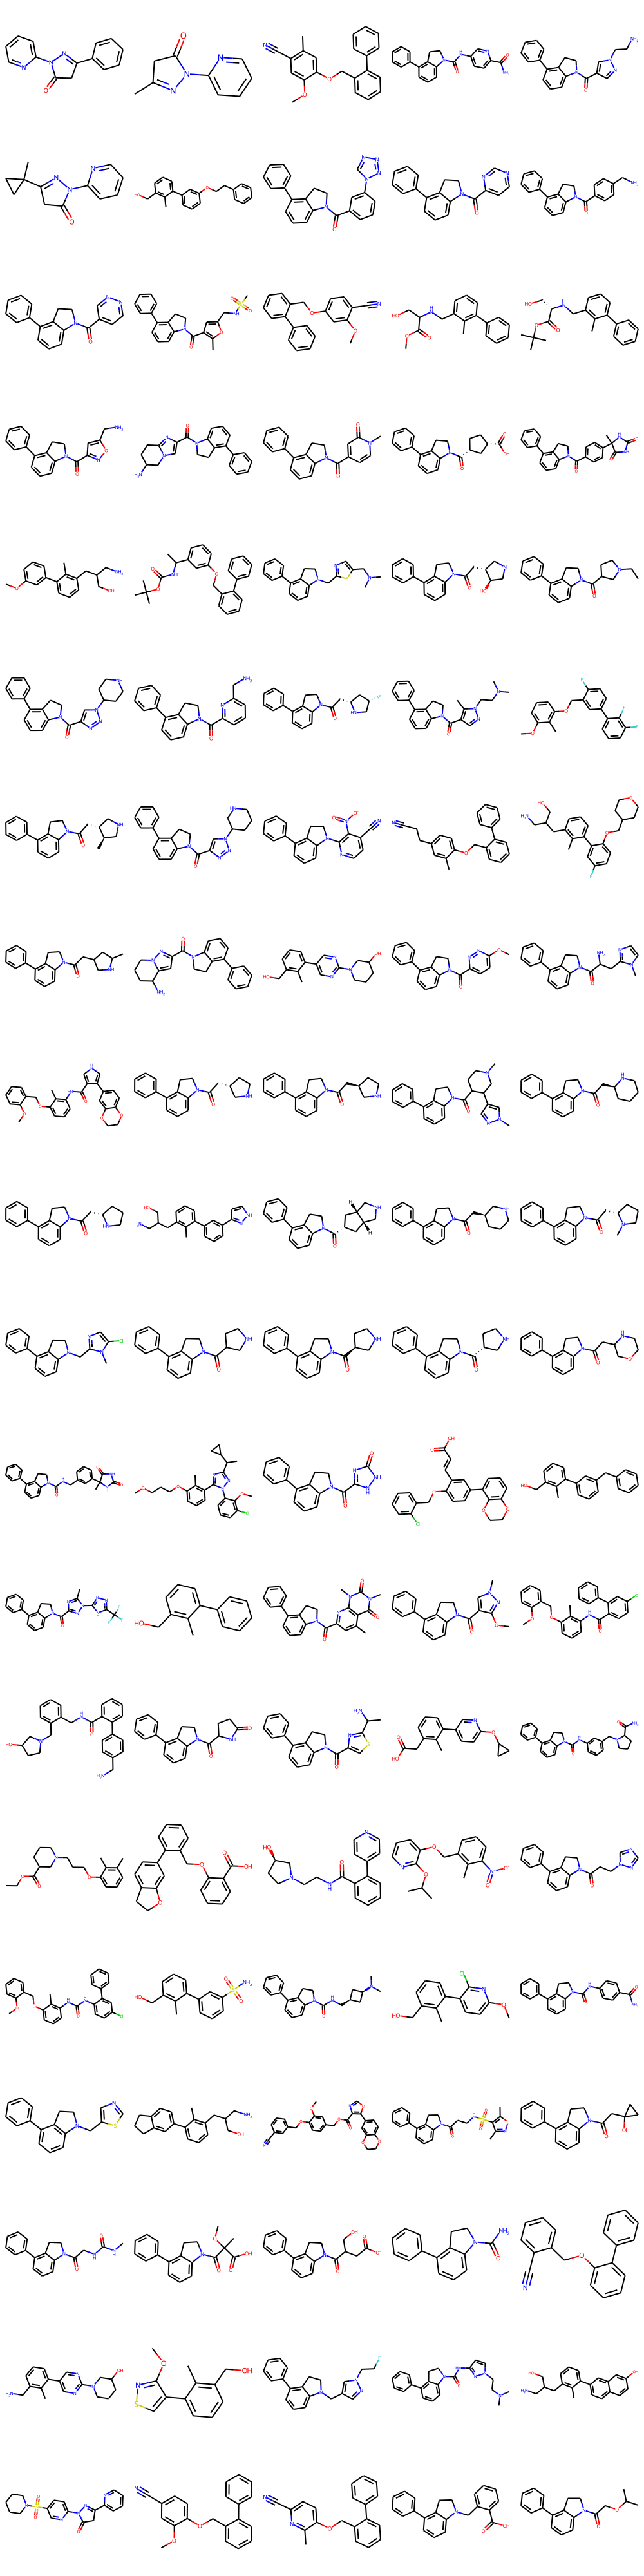

In [11]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.drawMolsSameScale=False
d = Draw.MolsToGridImage(winners,molsPerRow=5,maxMols=100)
display(d)

# Inspection of presence of dihydroindole in the ChEMBL actives, i.e. the training set

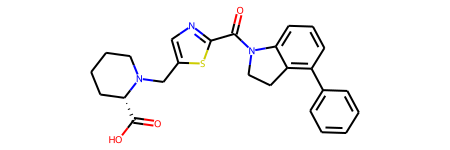

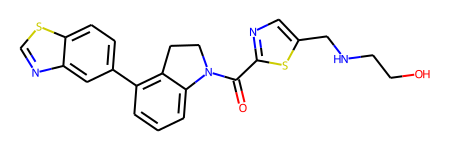

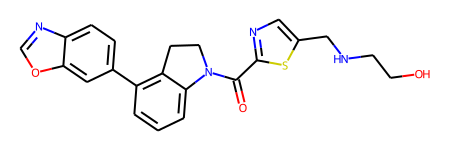

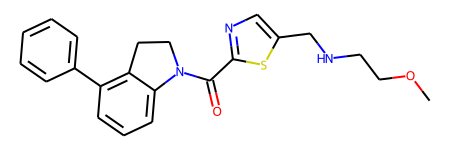

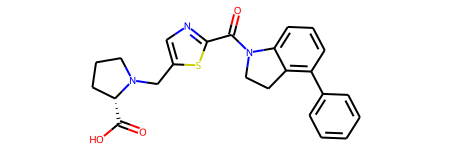

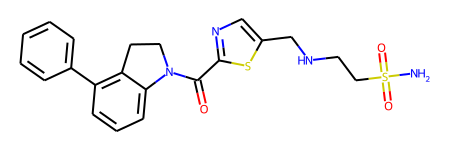

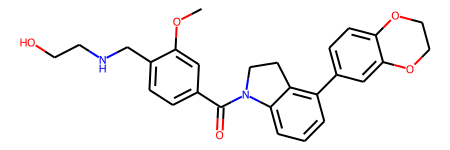

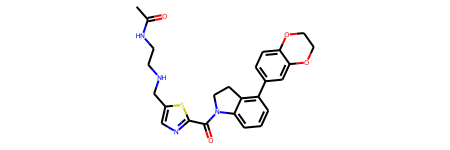

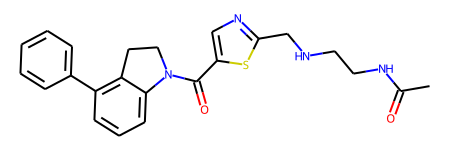

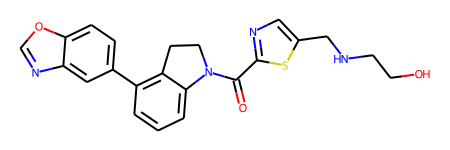

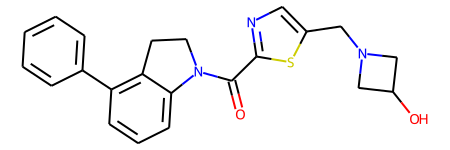

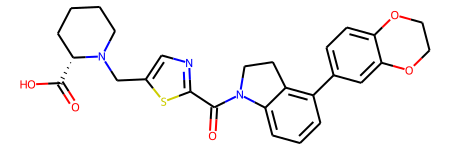

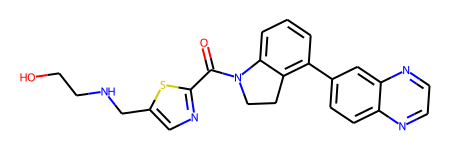

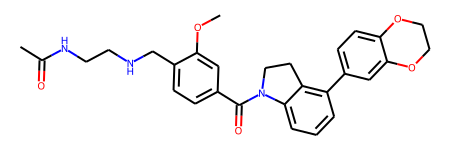

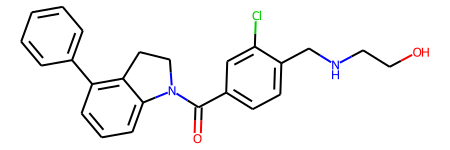

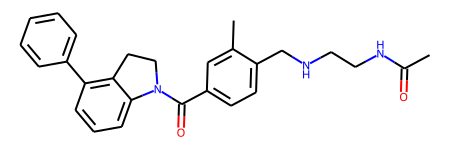

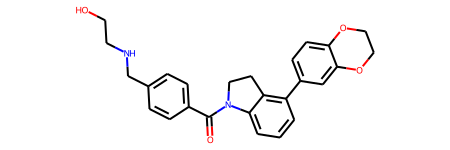

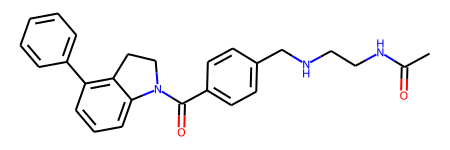

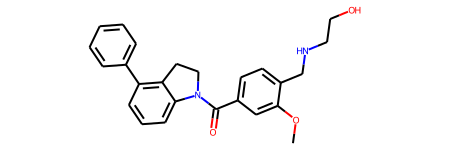

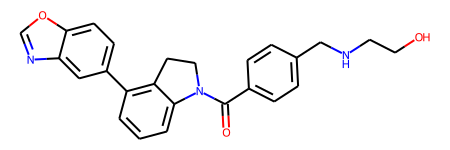

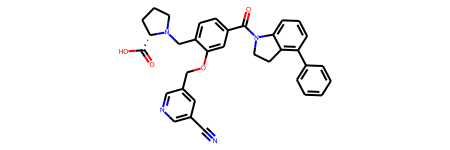

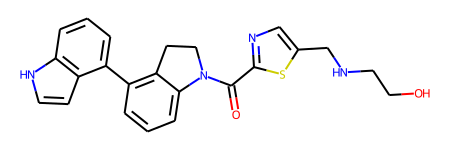

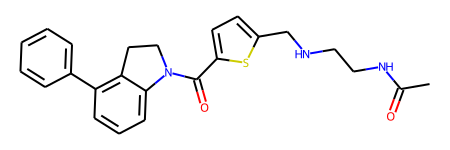

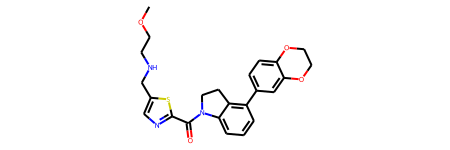

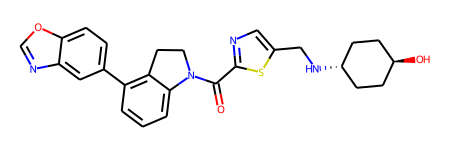

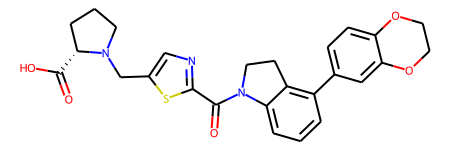

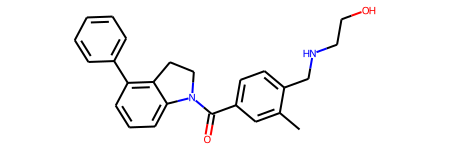

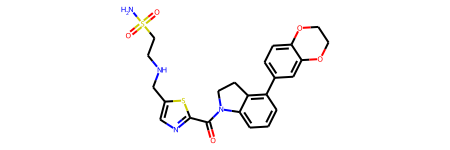

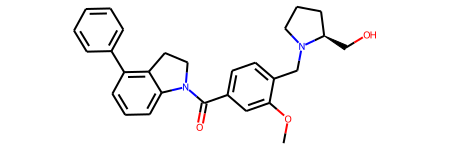

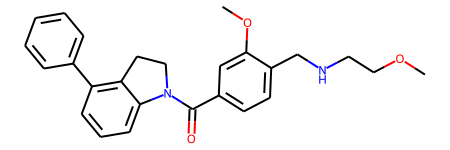

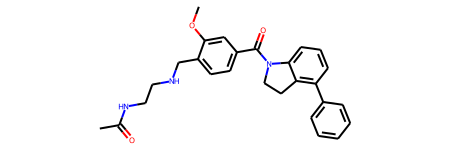

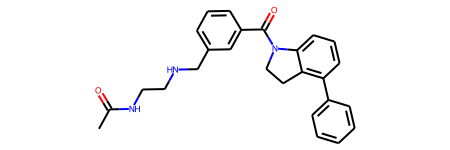

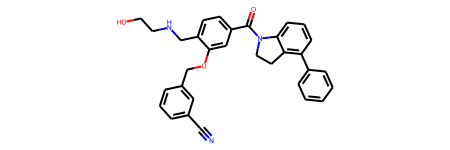

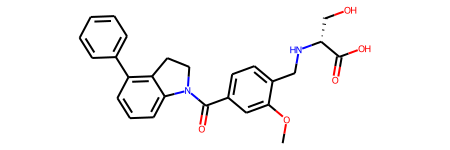

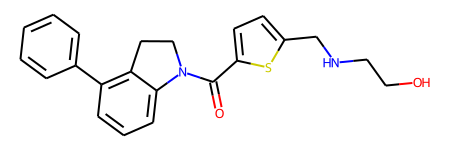

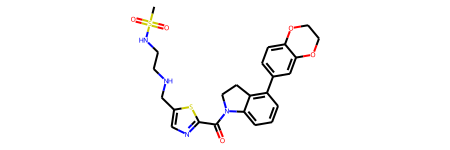

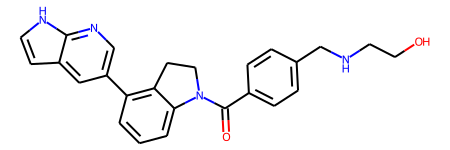

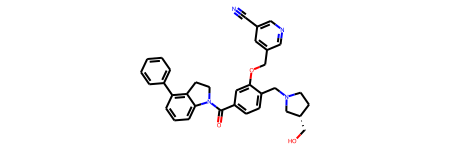

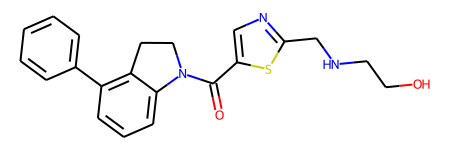

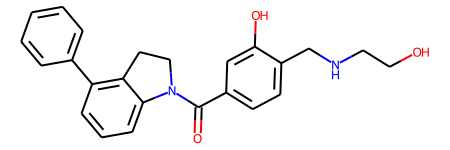

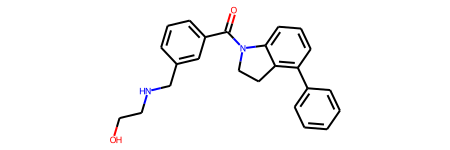

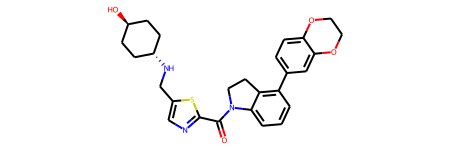

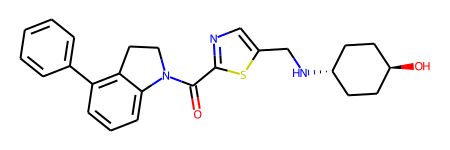

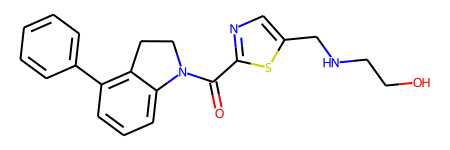

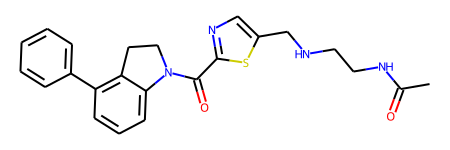

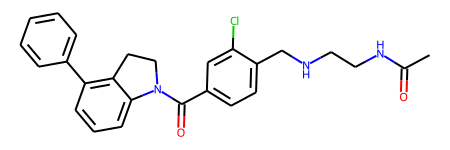

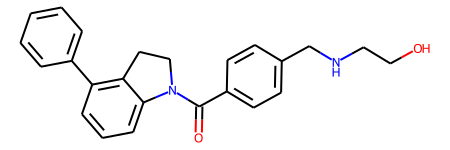

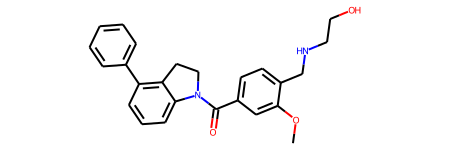

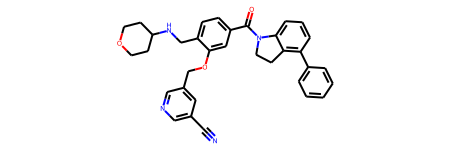

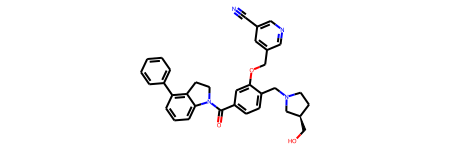

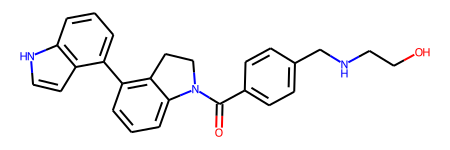

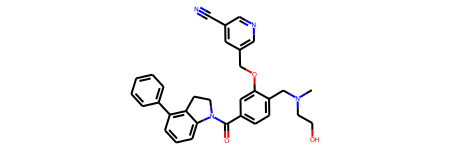

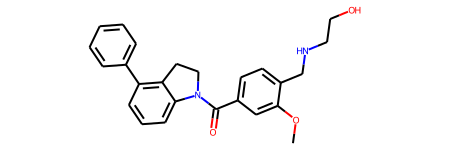

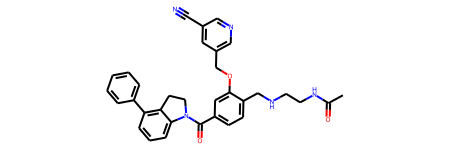

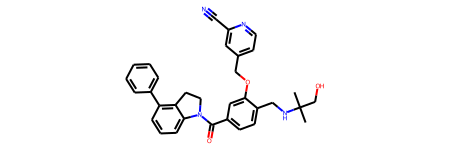

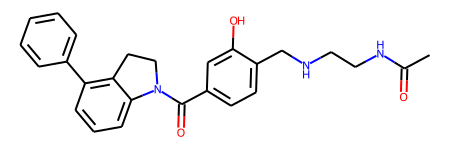

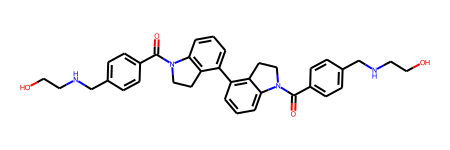

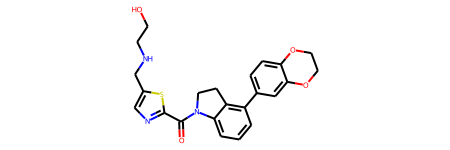

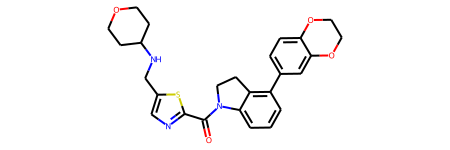

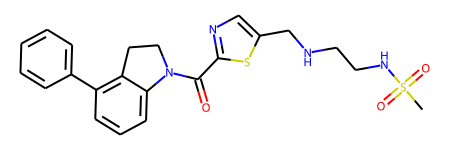

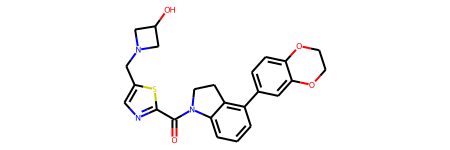

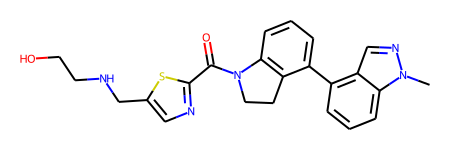

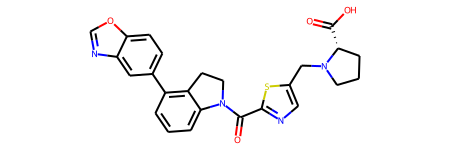

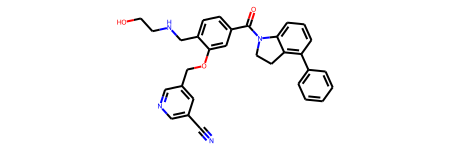

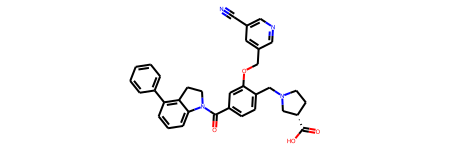

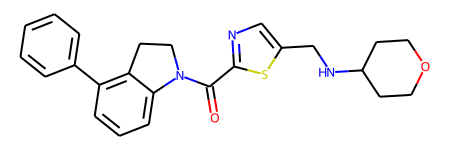

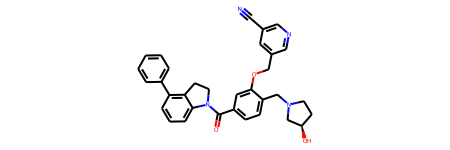

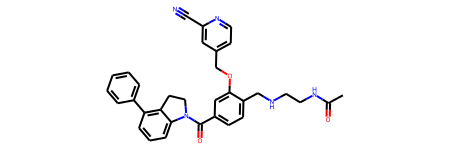

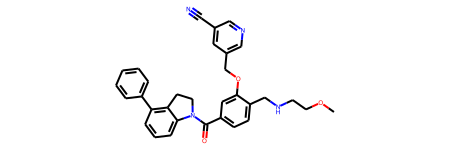

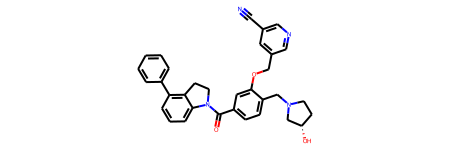

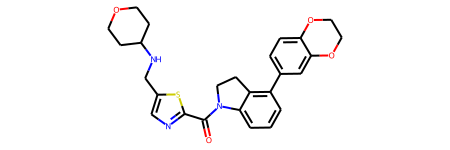

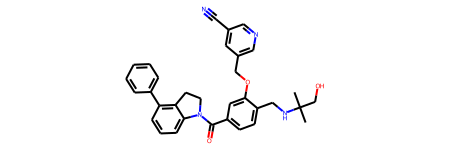

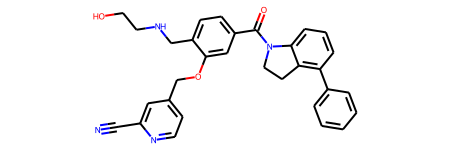

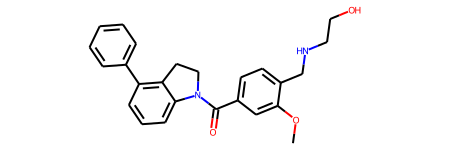

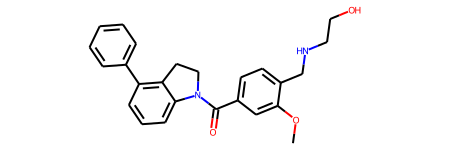

IndexError: list index out of range

In [12]:
df_chembl = pd.read_csv("data/PDL1-CHEMBL.csv", sep=";")
mols = []
y = []

threshold = 6.0  

for i, row in df_chembl.iterrows():
    smiles = row["Smiles"]
    try:
        pchembl = float(row["pChEMBL Value"])
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            if pchembl >= threshold:
                mols.append(mol)
    except:
        continue  

#df_paper = pd.read_excel("data/pharmaceuticals-1710563-supplementary.xlsx")
#smiles_paper = list(set(df_paper[df_paper["Unnamed: 2"] == "ACTIVE"]["Unnamed: 3"]))
#mols = [Chem.MolFromSmiles(smi) for smi in smiles_paper]
p = Chem.MolFromSmarts("c1cccc2c1[CH2][CH2]N2C=O")
#p = Chem.MolFromSmarts("[#6]1[#6][#7][#7][#6]1")
matches = [m for m in mols if m.HasSubstructMatch(p)]
for i in range(2000):
    display(matches[i])

# Interpretation
We get feature importances directly from sklearn RF. They are computed as follows "they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree."

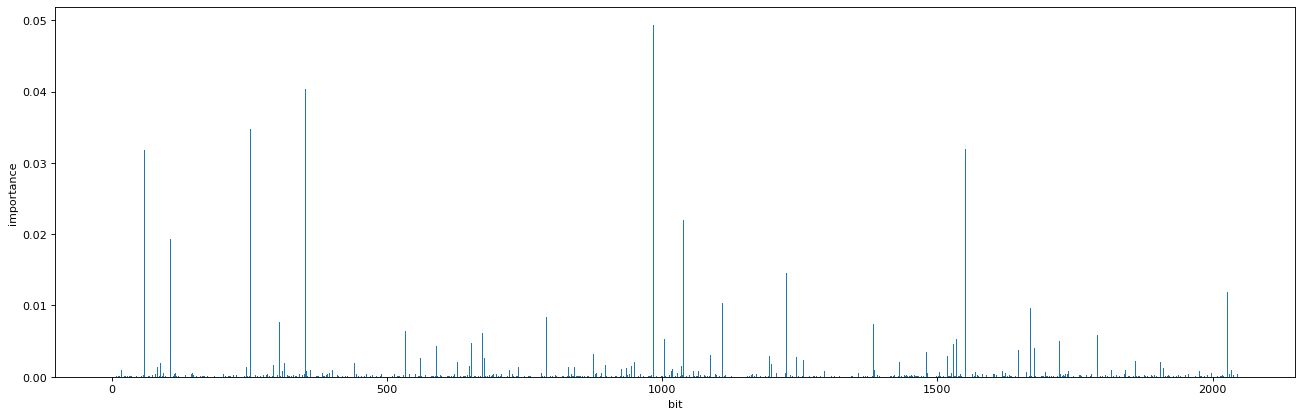

[ 984  352  596  252 1551   60 1597 1039  745  107  222 1349  836 1226
  431 1452 1815 2027 1970  645 1160 1110 1656 1669  255  790  736  305
  653 1384  142  547  534  674 1791 1603 1763 1004 1535  635 1722 1703
 1347  654 1529 1136 1712   77  590 1676]


In [13]:
importances_bits = rf_ecfp_model.feature_importances_

figure(figsize=(20, 6), dpi=80)
plt.bar([i for i in range(len(importances_bits))],importances_bits)
plt.xlabel("bit")
plt.ylabel("importance")
plt.show()
best_50_bits = np.argsort(importances_bits)[::-1][:50]
print(best_50_bits)

984 ---------------------


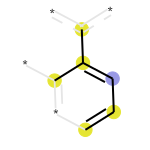

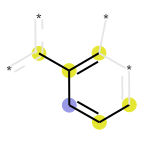

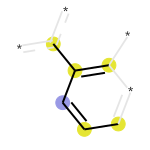

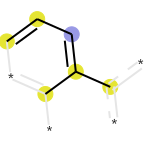

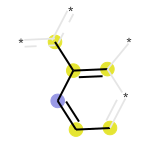

352 ---------------------


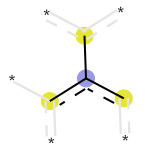

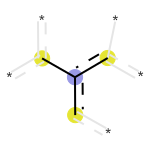

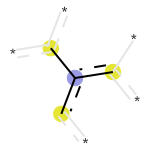

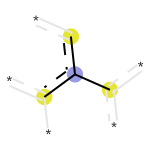

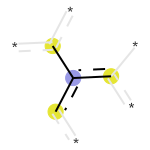

596 ---------------------


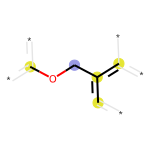

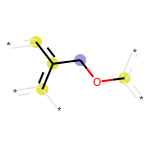

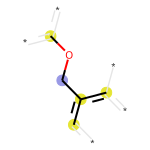

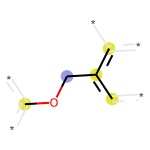

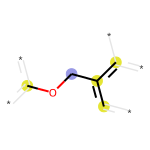

252 ---------------------


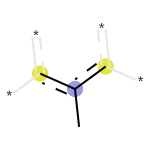

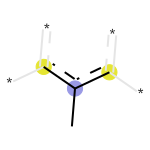

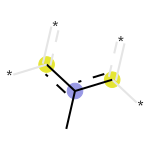

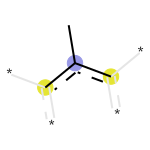

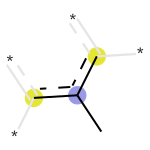

1551 ---------------------


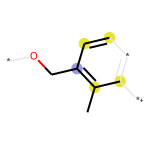

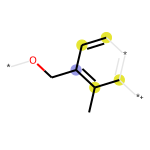

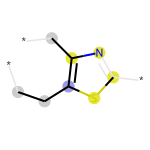

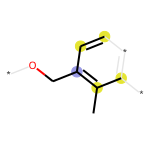

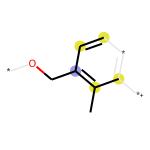

60 ---------------------


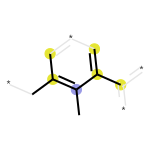

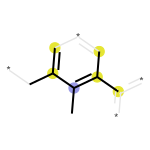

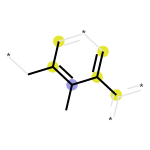

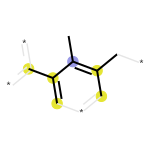

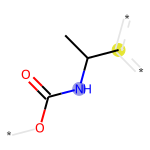

1597 ---------------------


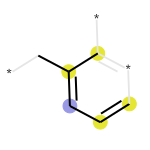

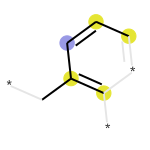

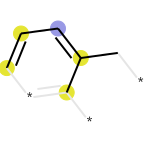

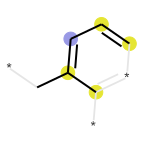

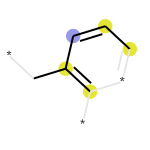

1039 ---------------------


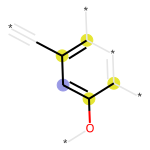

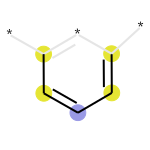

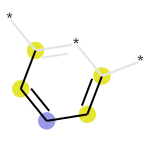

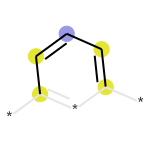

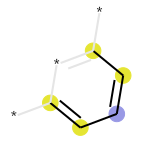

745 ---------------------


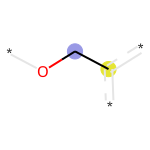

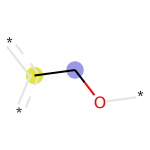

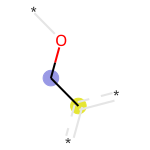

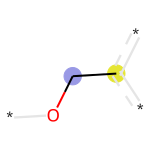

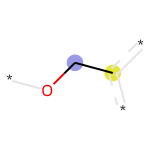

107 ---------------------


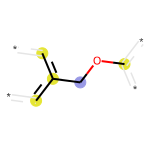

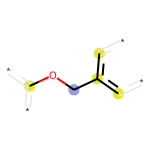

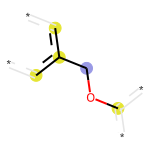

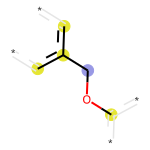

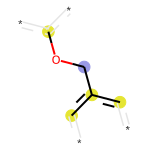

222 ---------------------


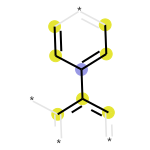

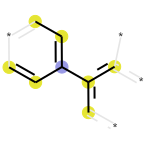

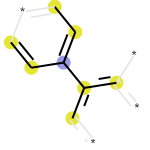

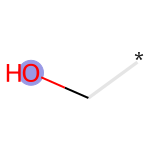

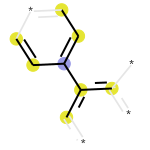

1349 ---------------------


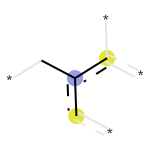

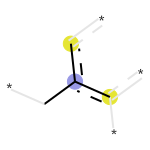

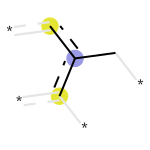

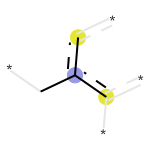

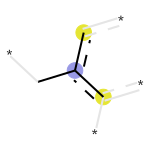

836 ---------------------


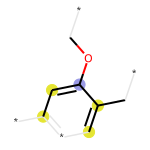

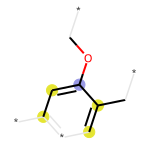

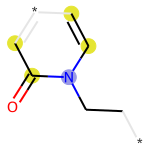

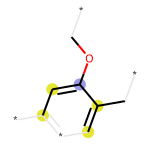

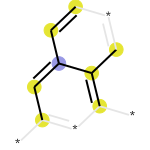

1226 ---------------------


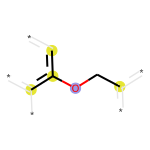

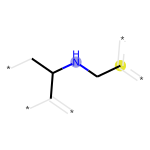

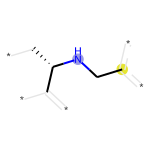

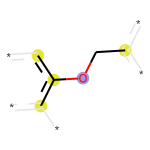

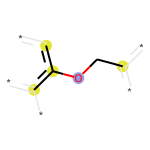

431 ---------------------


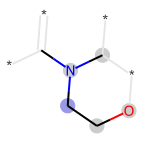

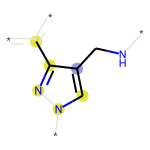

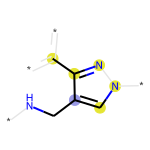

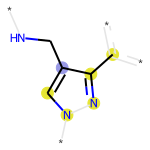

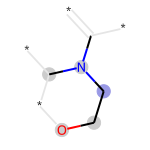

1452 ---------------------


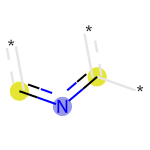

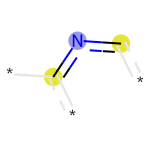

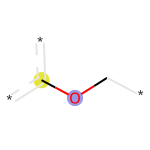

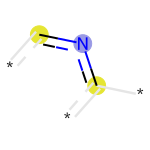

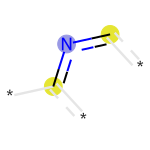

1815 ---------------------


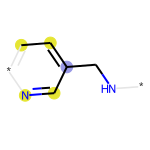

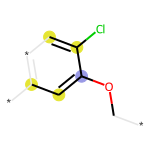

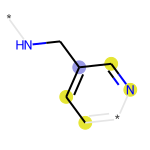

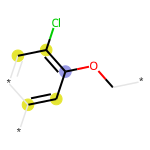

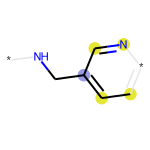

2027 ---------------------


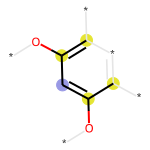

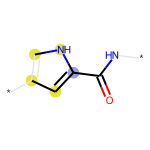

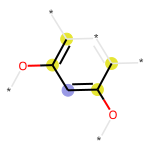

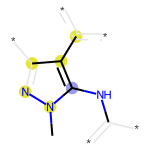

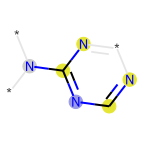

1970 ---------------------


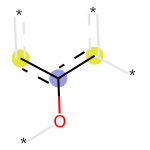

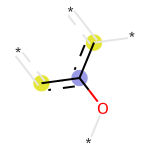

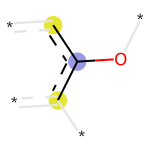

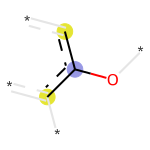

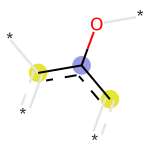

645 ---------------------


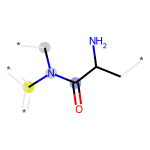

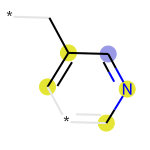

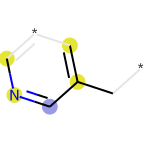

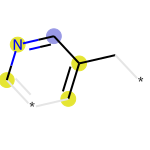

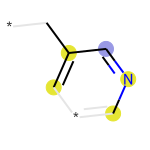

1160 ---------------------


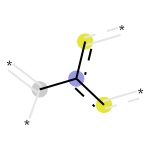

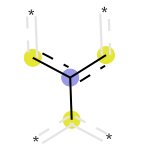

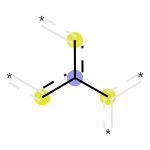

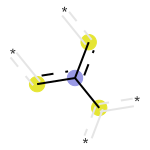

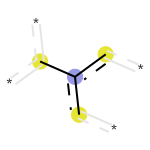

1110 ---------------------


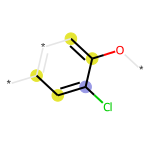

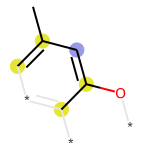

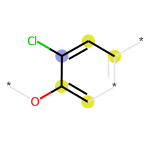

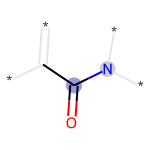

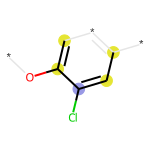

1656 ---------------------


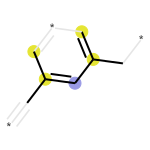

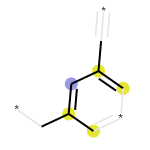

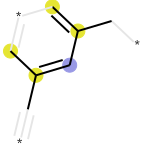

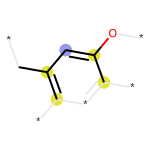

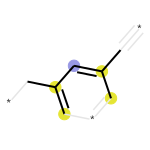

1669 ---------------------


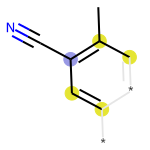

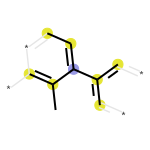

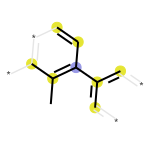

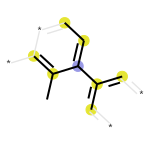

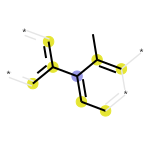

255 ---------------------


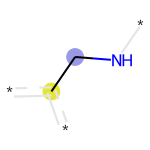

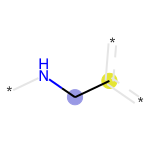

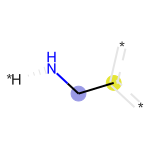

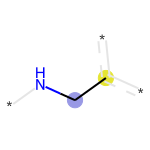

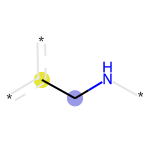

790 ---------------------


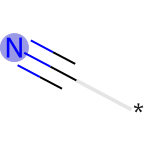

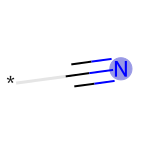

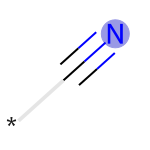

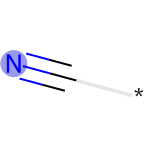

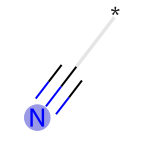

736 ---------------------


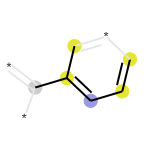

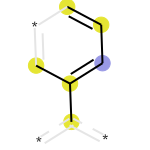

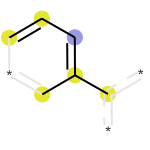

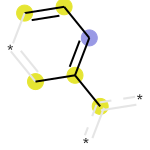

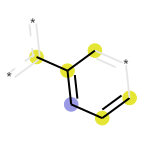

305 ---------------------


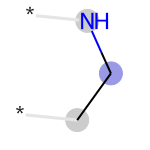

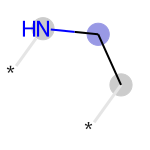

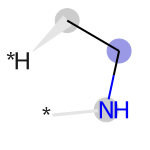

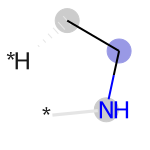

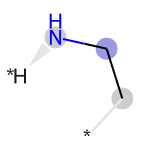

653 ---------------------


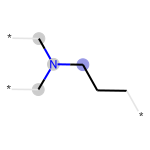

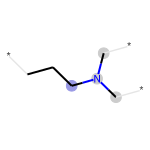

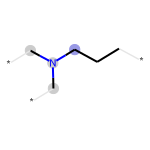

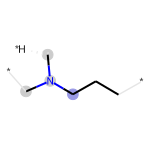

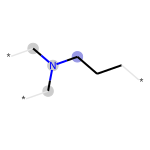

1384 ---------------------


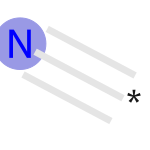

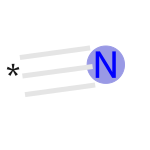

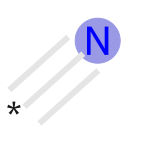

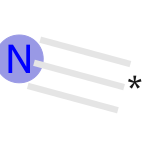

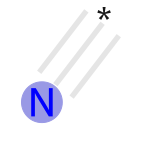

142 ---------------------


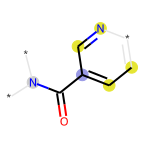

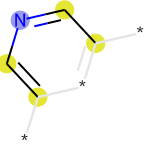

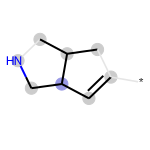

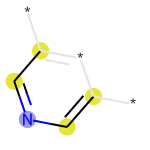

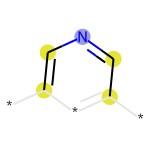

547 ---------------------


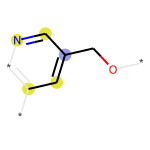

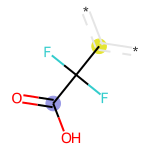

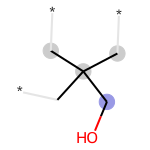

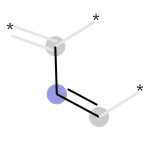

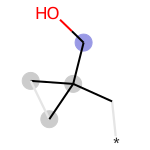

534 ---------------------


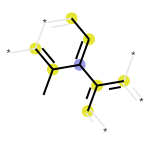

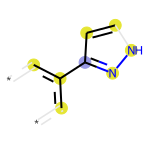

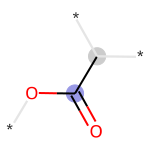

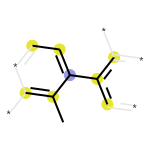

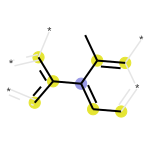

674 ---------------------


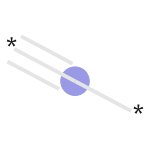

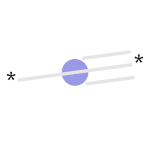

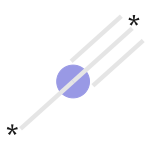

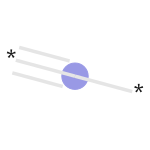

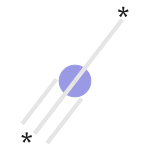

1791 ---------------------


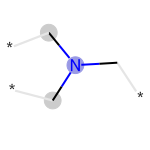

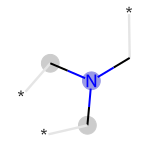

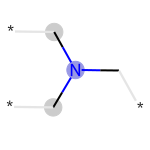

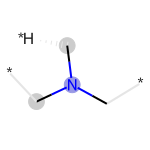

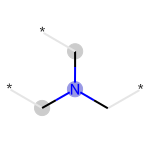

1603 ---------------------


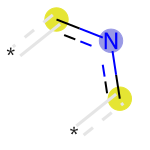

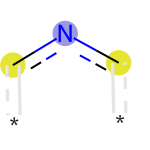

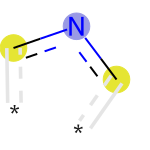

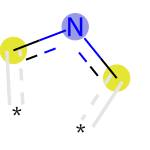

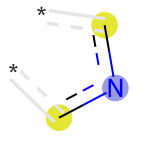

1763 ---------------------


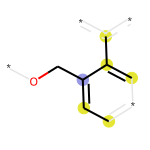

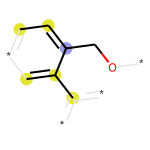

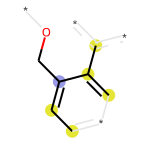

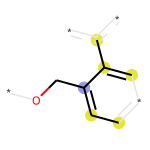

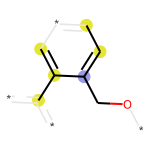

1004 ---------------------


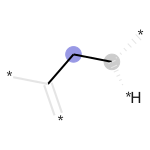

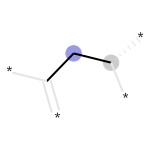

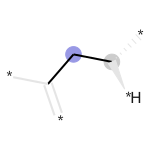

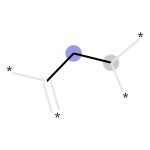

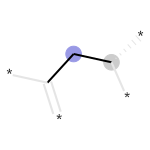

1535 ---------------------


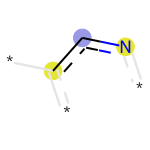

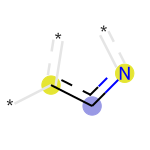

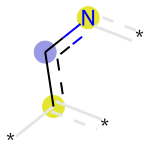

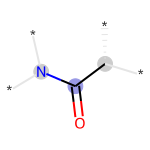

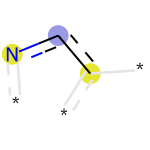

635 ---------------------


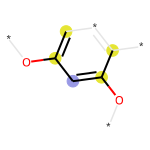

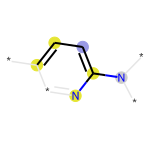

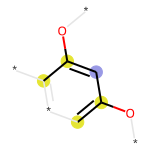

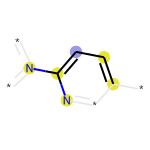

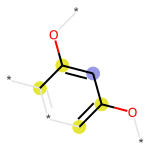

1722 ---------------------


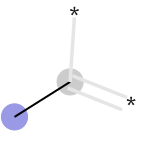

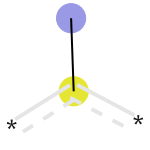

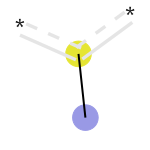

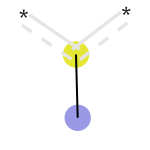

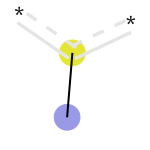

1703 ---------------------


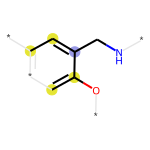

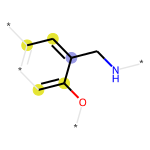

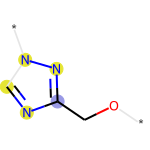

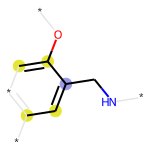

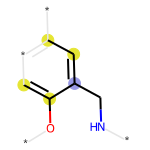

1347 ---------------------


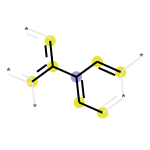

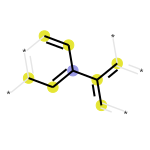

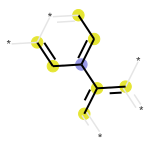

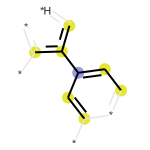

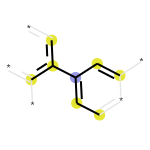

654 ---------------------


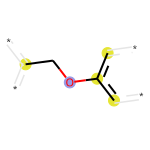

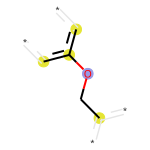

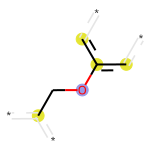

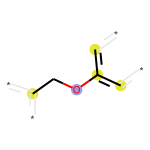

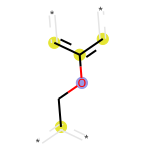

1529 ---------------------


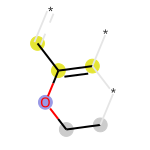

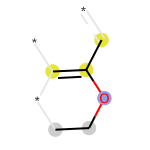

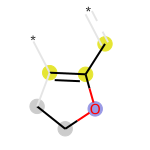

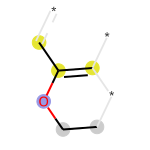

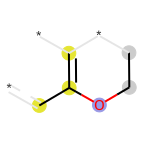

1136 ---------------------


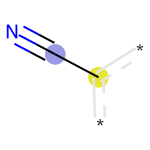

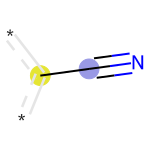

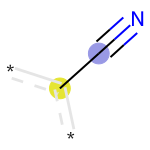

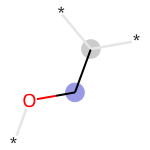

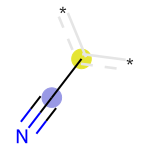

1712 ---------------------


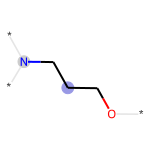

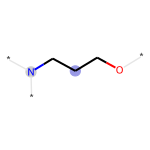

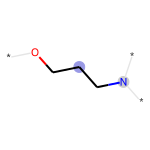

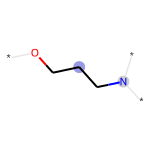

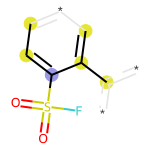

77 ---------------------


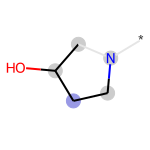

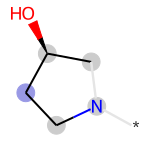

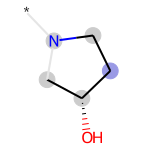

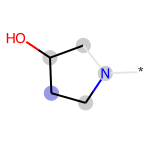

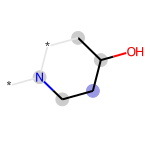

590 ---------------------


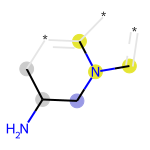

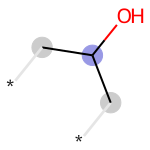

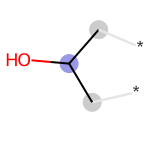

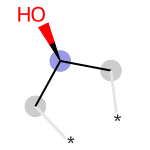

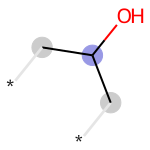

1676 ---------------------


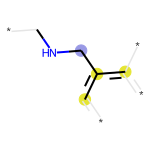

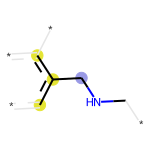

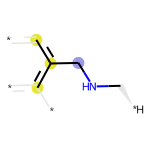

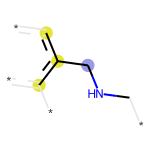

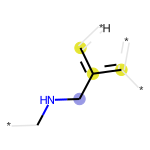

In [14]:
for bestbit in best_50_bits:
    print(bestbit,"---------------------")
    counter = 0
    for i in range(len(winners)):
        try:
            mol = winners[i]
            ao = rdFingerprintGenerator.AdditionalOutput()
            ao.AllocateBitInfoMap()
            fp = MFPGEN.GetFingerprint(mol,additionalOutput=ao)
            bi = ao.GetBitInfoMap()
            mfp2_svg = Draw.DrawMorganBit(mol, bestbit, bi, useSVG=True)
            display(mfp2_svg)
            if list(fp)[bestbit] == 1:
                counter += 1
            else:
                print(fp[bestbit])
            if counter >= 5:
                break
        except Exception as e:
            pass#print(e)